In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import TransformerEncoderLayer
import torch.nn.functional as F
from utils_tabpfn_knn import *


def maskmean(x, mask, dim):
    x = torch.where(mask, x, 0)
    return x.sum(dim=dim, keepdim=True) / mask.sum(dim=dim, keepdim=True)


def maskstd(x, mask, dim=0):
    num = mask.sum(dim=dim, keepdim=True)
    mean = maskmean(x, mask, dim=0)
    diffs = torch.where(mask, mean - x, 0)
    return ((diffs**2).sum(dim=0, keepdim=True) / (num - 1)) ** 0.5


def normalize_data(data, eval_pos):
    mask = ~torch.isnan(data[:eval_pos])
    mean = maskmean(data[:eval_pos], mask, dim=0)
    std = maskstd(data[:eval_pos], mask, dim=0) + 1e-6
    data = (data - mean) / std
    return torch.clip(data, min=-100, max=100)


def clip_outliers(X, eval_pos, n_sigma=4):
    assert len(X.shape) == 3, "X must be T,B,H"
    mask = ~torch.isnan(X[:eval_pos])
    mean = maskmean(X[:eval_pos], mask, dim=0)
    cutoff = n_sigma * maskstd(X[:eval_pos], ~torch.isnan(X[:eval_pos]), dim=0)
    mask = mask & (X[:eval_pos] >= mean - cutoff) & (X[:eval_pos] <= mean + cutoff)
    cutoff = n_sigma * maskstd(X[:eval_pos], ~torch.isnan(X[:eval_pos]), dim=0)
    return torch.clip(X, mean - cutoff, mean + cutoff)


def convert_to_torch_tensor(input):
    if isinstance(input, np.ndarray):
        return torch.from_numpy(input)
    elif torch.is_tensor(input):
        return input
    else:
        raise TypeError("Input must be a NumPy array or a PyTorch tensor.")

class PFN(nn.Module):
    def __init__(
        self,
        dropout,
        embedding_normalization,
        n_out,
        nhead,
        nhid,
        ninp,
        nlayers,
        norm_first,
        num_features,
    ):
        super().__init__()
        self.n_out = n_out
        self.embedding_normalization = embedding_normalization
        self.transformer_encoder = nn.ModuleList(
            [
                TransformerEncoderLayer(
                    activation="gelu",
                    d_model=ninp,
                    dim_feedforward=nhid,
                    dropout=dropout,
                    nhead=nhead,
                    norm_first=norm_first,
                )
                for _ in range(nlayers)
            ]
        )
        self.num_features = num_features
        self.encoder = nn.Linear(num_features, ninp)
        self.y_encoder = nn.Linear(1, ninp)
        self.decoder = nn.Sequential(
            nn.Linear(ninp, nhid), nn.GELU(), nn.Linear(nhid, n_out)
        )

    def forward(
        self,
        x_src,
        y_src,
        eval_pos,
        normalization,
        outlier_clipping,
        nan_replacement,
        used_features=None,
    ):
        if normalization:
            x_src = normalize_data(x_src, eval_pos)
        if outlier_clipping:
            x_src = clip_outliers(x_src, eval_pos, n_sigma=4)
        # check if this is after or before the clip outliers
        if used_features is not None:
            x_src = x_src / (used_features / 100)
        if nan_replacement is not None:
            x_src = torch.nan_to_num(x_src, nan=nan_replacement)
        x_src = self.encoder(x_src)
        if self.embedding_normalization:
            x_src = F.normalize(x_src, p=2, dim=-1)
        y_src = self.y_encoder(y_src.unsqueeze(-1))
        train_x = x_src[:eval_pos] + y_src[:eval_pos]
        src = torch.cat([train_x, x_src[eval_pos:]], 0)
        condition = torch.arange(src.shape[0]).to(src.device) >= eval_pos
        attention_mask = condition.repeat(src.shape[0], 1)
        for layer in self.transformer_encoder:
            src = layer(src, attention_mask)
        src = self.decoder(src)
        return src[eval_pos:]

    def predict(
        self,
        device,
        nan_replacement,
        normalization,
        outlier_clipping,
        return_logits,
        temperature,
        test_x,
        train_x,
        train_y,
    ):
        to_numpy = not torch.is_tensor(train_x)
        train_x, train_y, test_x = (
            convert_to_torch_tensor(train_x).to(device).float(),
            convert_to_torch_tensor(train_y).to(device).float(),
            convert_to_torch_tensor(test_x).to(device).float(),
        )
        dim = train_x.dim()
        if dim == 2:
            train_x = train_x.unsqueeze(1)
            test_x = test_x.unsqueeze(1)
            train_y = train_y.unsqueeze(1)
        else:
            assert False, "Predict only supports one dataset at a time"

        seq_len, batch_size, n_features = train_x.shape
        num_classes = len(torch.unique(train_y))
        test_seq_len = test_x.shape[0]
        full_x = torch.cat((train_x, test_x), dim=0)
        zero_feature_padding = torch.zeros(
            (
                seq_len + test_seq_len,
                batch_size,
                self.num_features - n_features,
            )
        ).to(device)
        full_x = torch.cat([full_x, zero_feature_padding], -1)

        y_padding = torch.zeros((test_seq_len, batch_size)).to(device)
        full_y = torch.cat([train_y, y_padding], dim=0)

        print("full_x.shape", full_x.shape)
        print("full_y.shape", full_y.shape)

        # forward
        output = self.forward(
            eval_pos=seq_len,
            nan_replacement=nan_replacement,
            normalization=normalization,
            outlier_clipping=outlier_clipping,
            x_src=full_x,
            y_src=full_y,
        )
        output = output[..., :num_classes] / temperature
        if not return_logits:
            output = torch.nn.functional.softmax(output, dim=-1)
        if dim == 2:
            output.squeeze_(1)
        if to_numpy:
            output = output.detach().cpu().numpy()
        return output

    @classmethod
    def load(cls, path, device):
        model_state, config = torch.load(path, map_location=device)
        assert config["max_num_classes"] > 2
        model = PFN(
            dropout=config["dropout"],
            embedding_normalization=config["embedding_normalization"],
            n_out=config["max_num_classes"],
            nhead=config["nhead"],
            nhid=config["emsize"] * config["nhid_factor"],
            ninp=config["emsize"],
            nlayers=config["nlayers"],
            norm_first=config["norm_first"],
            num_features=config["max_num_features"],
        )

        module_prefix = "module."
        model_state = {k.replace(module_prefix, ""): v for k, v in model_state.items()}
        model.load_state_dict(model_state)
        model.to(device)
        model.eval()
        return model, config

    @classmethod
    def load_old(cls, path, device):
        model_state, _, config = torch.load(path, map_location=device)
        assert config["max_num_classes"] > 2
        model = PFN(
            dropout=config["dropout"],
            embedding_normalization=False,
            n_out=config["max_num_classes"],
            nhead=config["nhead"],
            nhid=config["emsize"] * config["nhid_factor"],
            ninp=config["emsize"],
            nlayers=config["nlayers"],
            norm_first=False,
            num_features=config["num_features"],
        )

        module_prefix = "module."
        model_state = {
            k.replace(module_prefix, "").replace("layers.", ""): v
            for k, v in model_state.items()
        }
        del model_state["criterion.weight"]
        model.load_state_dict(model_state)
        model.to(device)
        model.eval()
        return model, config

In [3]:
device = "cpu"
model, _ = PFN.load_old(device=device, path="/scratch/lgrinszt/original_tabpfn/TabPFN/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_42.cpkt")
model.eval()

class Args:
    context_length = 200
    class_choice = "equal"
    knn_mode="multiclass"
    dynamic_context_length=True
    fix_missing=False


new_model = PFKNNClassifier(model=model, device=device, args=Args(),
                            knn_mode="multiclass",
                            fix_missing=False,
                            use_one_hot_emb=False,
                            embedding_type="raw",
                            normalize_data=True)
                            


In [66]:
from sklearn.cluster import KMeans

class KmeanTabPFNClassifier:
    def __init__(self,n_clusters=3, device="cpu", N_ensemble_configurations=1):
        self.base_classifier = TabPFNClassifier(device=device,
                                                N_ensemble_configurations=N_ensemble_configurations)
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters)

    def fit(self, X, y):
        # Cluster the data
        self.kmeans.fit(X)
        self.X_train = X
        self.y_train = y
        
        # # Train a classifier for each cluster
        # for cluster in range(self.n_clusters):
        #     cluster_indices = np.where(clusters == cluster)
        #     X_cluster = X[cluster_indices]
        #     y_cluster = y[cluster_indices]
        #     self.classifiers[cluster].fit(X_cluster, y_cluster)

    def predict(self, X):
        clusters = self.kmeans.predict(X)
        
        # Predict using the classifier for the corresponding cluster
        predictions = np.zeros(X.shape[0])
        for cluster in range(self.n_clusters):
            train_clusters = self.kmeans.predict(self.X_train)
            train_cluster_indices = np.where(train_clusters == cluster)
            X_train_cluster = self.X_train[train_cluster_indices]
            y_train_cluster = self.y_train[train_cluster_indices]
            print(f"Shape of X_train_cluster: {X_train_cluster.shape}")
            print(f"Number of each classes", np.unique(y_train_cluster, return_counts=True))
            self.base_classifier.fit(X_train_cluster, y_train_cluster, overwrite_warning=True)
            cluster_indices = np.where(clusters == cluster)
            if len(cluster_indices[0]) > 0:
                predictions[cluster_indices] = self.base_classifier.predict(X[cluster_indices])
        
        return predictions

# Example usage
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kmean_tabpfn_classifier = KmeanTabPFNClassifier(n_clusters=3)
kmean_tabpfn_classifier.fit(X_train, y_train)
y_pred = kmean_tabpfn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Shape of X_train_cluster: (1646, 26)
Number of each classes (array([0, 1]), array([1610,   36]))
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Shape of X_train_cluster: (4452, 26)
Number of each classes (array([0, 1]), array([ 720, 3732]))
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Shape of X_train_cluster: (1967, 26)
Number of each classes (array([0, 1]), array([1673,  294]))
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Accuracy: 0.9801685671789787


(1500, 2)


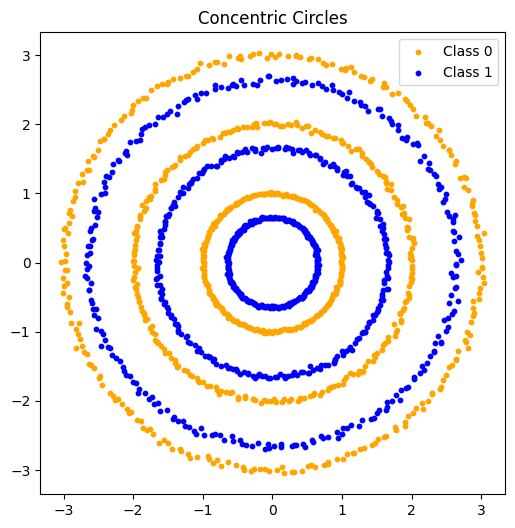

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

def generate_concentric_circles_data(n_points=1000, n_circles=2, noise=0.05):
    X_list = []
    y_list = []
    
    # Adjust the circles to be concentric
    for i in range(1, n_circles):
        new_X, new_y = make_circles(n_samples=n_points // n_circles, factor=1 - 0.35 / i, noise=noise, shuffle=True)
        new_X = new_X * i
        X_list.append(new_X)
        y_list.append(new_y)
    
    return np.vstack(X_list), np.hstack(y_list)

def plot_data(X, y):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], s=10, color='orange', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], s=10, color='blue', label='Class 1')
    #plt.axis('equal')
    plt.title('Concentric Circles')
    plt.legend()
    plt.show()

# Example usage
X, y = generate_concentric_circles_data(n_points=2000, n_circles=4, noise=0.01)
print(X.shape)
plot_data(X, y)

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


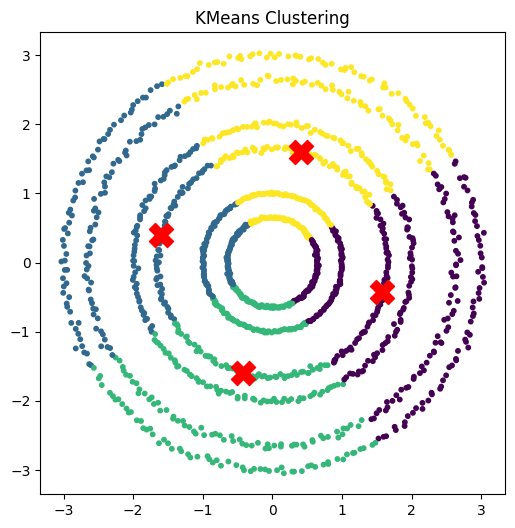

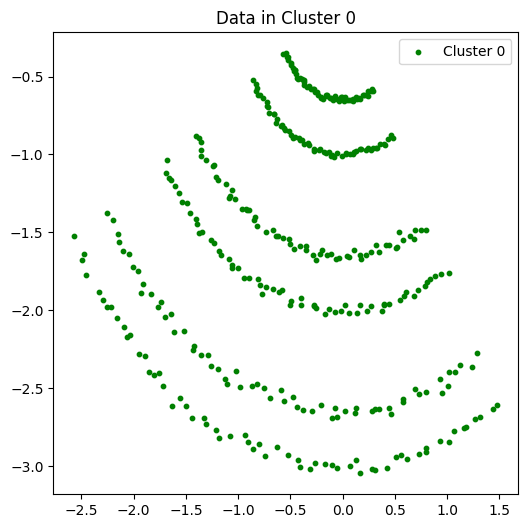

In [38]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.title('KMeans Clustering')
plt.show()

# Plot the data in cluster 0
plt.figure(figsize=(6, 6))
plt.scatter(X[y_kmeans == 2][:, 0], X[y_kmeans == 2][:, 1], s=10, color='green', label='Cluster 0')
plt.title('Data in Cluster 0')
plt.legend()
plt.show()



In [57]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tabpfn import TabPFNClassifier

X, y  = X[y_kmeans == 2],  y[y_kmeans == 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#model = TabPFNClassifier(device=device, N_ensemble_configurations=1)
#model.fit(X_train, y_train, overwrite_warning=True)
#model = new_model
model = TabPFNClassifier(device="cpu", N_ensemble_configurations=1)
#kmean_tabpfn_classifier = KmeanTabPFNClassifier(base_classifier=model, n_clusters=2)
#model = kmean_tabpfn_classifier
#kmean_tabpfn_classifier.fit(X_train, y_train)
model.fit(X_train, y_train)
#model = kmean_tabpfn_classifier()
#model.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = model.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Plot decision boundary
def plot_decision_boundary(model, X, y, ax=None, title="Decision Boundary"):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                         np.arange(y_min, y_max, 0.2))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    ax.set_title(title)

# Plot the decision boundary for the training data
plt.figure(figsize=(8, 6))
plot_decision_boundary(model, X_train, y_train)
plt.show()

# # Plot the decision boundary for the test data
# plt.figure(figsize=(8, 6))
# plot_decision_boundary(new_model, X_test, y_test, title="Decision Boundary (Test Data)")
# plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 38474 but corresponding boolean dimension is 1500

In [ ]:
accuracy

0.528125

In [67]:
from sklearn.datasets import make_classification

# Create toy data
#X_toy, y_toy = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=42)
import openml

task_id = 361062
task = openml.tasks.get_task(task_id)
print(task.get_dataset().name)
X, y = task.get_X_and_y()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the toy data to verify
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# restrict X_train to 1000 samples
X_train = X_train[:30_000]
y_train = y_train[:30_000]
# restrict X_test to 1000 samples
X_test = X_test[:1000]
y_test = y_test[:1000]


pol
Shape of X_train: (8065, 26)
Shape of y_train: (8065,)
Shape of X_test: (2017, 26)
Shape of y_test: (2017,)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/openml/tasks/functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
/tmp/ipykernel_2117015/2265344543.py:10: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure yo

In [68]:
new_model.fit(X_train, y_train)

test
sizes_per_class_ [99, 101]


PFKNNClassifier(args=<__main__.Args object at 0x7f24472a7a90>, device='cpu',
                model=PFN(
  (transformer_encoder): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0....
      (dropout1): Dropout(p=0.0, inplace=False)
      (dropout2): Dropout(p=0.0, inplace=False)
    )
  )
  (encoder): Linear(in_features=100, out_features=512, bias=True)
  (y_encoder): Linear(in_features=1, out_features=512, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
))

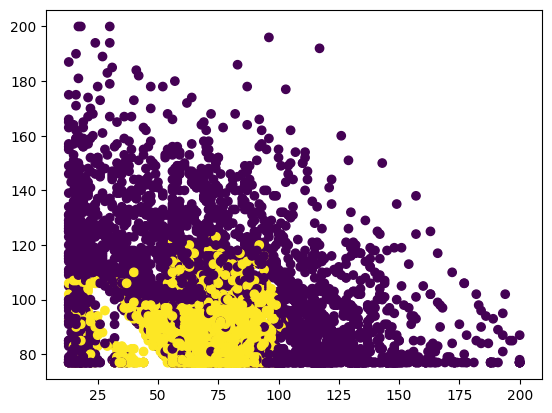

In [60]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

In [61]:
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred = new_model.predict(X_test)

# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Compute the ROC AUC score
# roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
# print("ROC AUC Score:", roc_auc)




X.shape (1000, 26)


100%|██████████| 1000/1000 [01:03<00:00, 15.63it/s]

Accuracy: 0.961


In [69]:
from tabpfn import TabPFNClassifier
clf = TabPFNClassifier(device="cpu", N_ensemble_configurations=1)
# Fit the classifier on the training data
clf.fit(X_train[:3000], y_train[:3000], overwrite_warning=True)

# Predict the labels for the test data
y_pred_clf = clf.predict(X_test)

# Compute the accuracy
accuracy_clf = accuracy_score(y_test, y_pred_clf)
print("Accuracy of TabPFNClassifier (3K samples):", accuracy_clf)

clf.fit(X_train[:1000], y_train[:1000])

y_pred_clf =clf.predict(X_test)

# Compute the accuracy
accuracy_clf = accuracy_score(y_test, y_pred_clf)
print("Accuracy of TabPFNClassifier (1K samples):", accuracy_clf)


NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Accuracy of TabPFNClassifier (3K samples): 0.97
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Accuracy of TabPFNClassifier (1K samples): 0.957


In [70]:
from tabpfn import TabPFNClassifier
clf = KmeanTabPFNClassifier(device="cpu", N_ensemble_configurations=16, n_clusters=5)
# Fit the classifier on the training data
clf.fit(X_train, y_train,)#, overwrite_warning=True)

# Predict the labels for the test data
y_pred_clf = clf.predict(X_test)

# Compute the accuracy
accuracy_clf = accuracy_score(y_test, y_pred_clf)
print("Accuracy of TabPFNClassifier (3K samples):", accuracy_clf)

clf.fit(X_train[:3000], y_train[:3000])

y_pred_clf =clf.predict(X_test)

# Compute the accuracy
accuracy_clf = accuracy_score(y_test, y_pred_clf)
print("Accuracy of TabPFNClassifier (1K samples):", accuracy_clf)


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Shape of X_train_cluster: (1609, 26)
Number of each classes (array([0, 1]), array([1369,  240]))
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Shape of X_train_cluster: (1585, 26)
Number of each classes (array([0, 1]), array([ 526, 1059]))
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Shape of X_train_cluster: (1888, 26)
Number of each classes (array([0, 1]), array([ 442, 1446]))
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Shape of X_train_cluster: (997, 26)
Number of each classes (array([0]), array([997]))


ValueError: The number of classes has to be greater than one; got 1 class

: 

In [ ]:
sq